In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta

# Data Preprocessing

In [3]:
data = yf.download(tickers='MSFT', start= '2016-03-1', end='2023-11-11')

[*********************100%%**********************]  1 of 1 completed


In [4]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-03-01,50.970001,52.590000,50.919998,52.580002,46.805725,33024500
2016-03-02,52.410000,52.959999,52.160000,52.950001,47.135101,29289900
2016-03-03,52.970001,52.970001,51.779999,52.349998,46.600990,24427800
2016-03-04,52.400002,52.450001,51.709999,52.029999,46.316120,33034200
2016-03-07,51.560001,51.799999,50.580002,51.029999,45.425941,38407800


In [5]:
df = data[['Close']]  

In [6]:
df.shape

(1940, 1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1940 entries, 2016-03-01 to 2023-11-10
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1940 non-null   float64
dtypes: float64(1)
memory usage: 30.3 KB


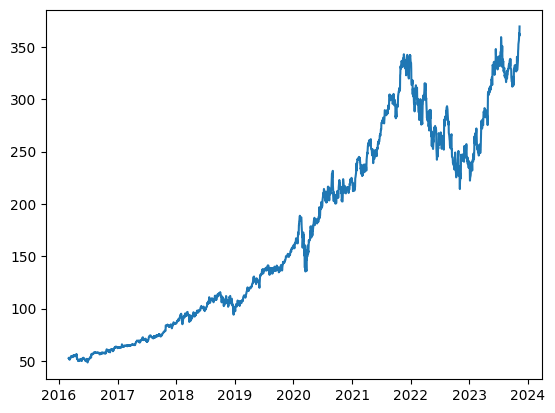

In [8]:
plt.plot(df.index, df)

In [9]:
# Apply scaling to all the values as LSTM is sensitive to scale of the data
# import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
# scaler = MinMaxScaler(feature_range=(0,1))
scaler = StandardScaler()
df = df.to_numpy()
df1 = scaler.fit(X=df[0:int(len(df)*0.75)])
df = scaler.transform(df)
# df = np.concatenate((df1,df2))

In [10]:
df

array([[-1.12788929],
       [-1.12300736],
       [-1.13092406],
       ...,
       [ 2.97056754],
       [ 2.93744937],
       [ 3.05593558]])

### Changing the dataframe to have previous n days price

In [11]:
def window_df(array, step):
    X = []
    Y = []
    for i in range(len(array)-(step+1)):
       x = array[i:i+step]
       X.append(x)  
       y = array[i+step]
       Y.append(y)
    return np.array(X), np.array(Y)

In [12]:
step = 5
X, Y = window_df(df, step)

In [13]:
len(X)

1934

### Train test split
As the data is sequential data, train-test split should not be done randomly, it should be strictly done from a specific date

In [14]:
X_train = X[0:int(len(X)*0.75)]
X_val = X[int(len(X)*0.75):int(len(X)*0.85)]
X_test = X[int(len(X)*0.85):]
Y_train = Y[0:int(len(X)*0.75)]
Y_val = Y[int(len(X)*0.75):int(len(X)*0.85)]
Y_test = Y[int(len(X)*0.85):]

In [15]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler(feature_range=(0,1))

# Y_train = scaler.fit_transform(Y_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)
# X_val = scaler.transform(X_val)
# Y_val = scaler.transform(Y_val)
# Y_test = scaler.transform(Y_test)

In [16]:
Y_test.shape

(291, 1)

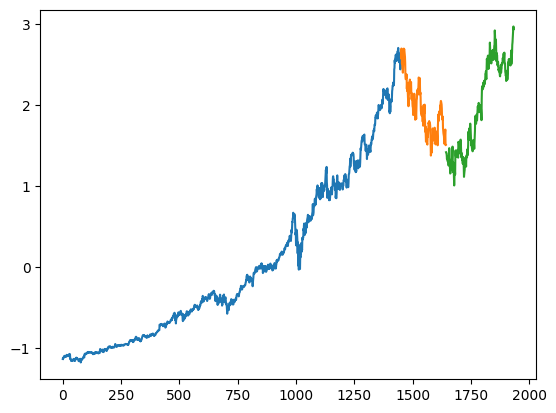

In [17]:
plt.plot(range(0,int(len(X)*0.75)),Y_train)
plt.plot(range(int(len(X)*0.75),int(len(X)*0.85)),Y_val)
plt.plot(range(int(len(X)*0.85),len(X)),Y_test)

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [19]:
step = 5
model = Sequential([
    layers.Input((step,1)),
    layers.LSTM(64),
    layers.Dense(32, activation='ReLU'),
    layers.Dense(16, activation='ReLU'),
    layers.Dense(1)
])

In [20]:
model.compile(loss='mse', optimizer=Adam(learning_rate = 0.001), metrics= ['mean_absolute_error'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 19,521
Trainable params: 19,521
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.fit(X_train, Y_train, shuffle=False, validation_data=(X_val,Y_val), epochs=10)

Epoch 1/10
46/46 [==============================] - 55s 239ms/step - loss: 0.6530 - mean_absolute_error: 0.6949 - val_loss: 0.8090 - val_mean_absolute_error: 0.8778
Epoch 2/10
46/46 [==============================] - 1s 17ms/step - loss: 0.1209 - mean_absolute_error: 0.2876 - val_loss: 0.0995 - val_mean_absolute_error: 0.2846
Epoch 3/10
46/46 [==============================] - 1s 17ms/step - loss: 0.0092 - mean_absolute_error: 0.0802 - val_loss: 0.0151 - val_mean_absolute_error: 0.0990
Epoch 4/10
46/46 [==============================] - 1s 15ms/step - loss: 0.0391 - mean_absolute_error: 0.1665 - val_loss: 0.0204 - val_mean_absolute_error: 0.1158
Epoch 5/10
46/46 [==============================] - 1s 14ms/step - loss: 0.0177 - mean_absolute_error: 0.1104 - val_loss: 0.0122 - val_mean_absolute_error: 0.0912
Epoch 6/10
46/46 [==============================] - 1s 14ms/step - loss: 0.0144 - mean_absolute_error: 0.0956 - val_loss: 0.0116 - val_mean_absolute_error: 0.0890
Epoch 7/10
46/46 [==

In [23]:
pred = model.predict(X).squeeze()

61/61 [==============================] - 1s 7ms/step


In [24]:
pred.shape

(1934,)

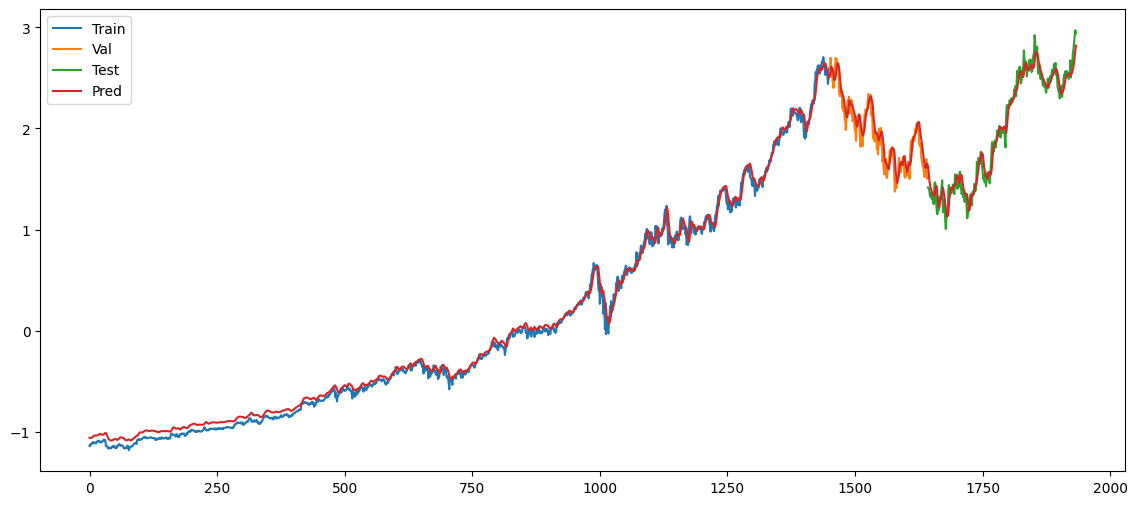

In [25]:
plt.figure(figsize=(14, 6))
plt.plot(range(0,int(len(X)*0.75)),Y_train)
plt.plot(range(int(len(X)*0.75),int(len(X)*0.85)),Y_val)
plt.plot(range(int(len(X)*0.85),len(X)),Y_test)
plt.plot(pred)
plt.legend(['Train', 'Val', 'Test', 'Pred'])


In [26]:
a = np.expand_dims(X_test[-1], axis=0)
a.shape


(1, 5, 1)

In [27]:
b = model.predict(np.expand_dims(X_test[-1], axis=0))

1/1 [==============================] - 0s 58ms/step


In [28]:
b.shape

(1, 1)

In [48]:
from collections import deque

a = (X_test[-1])
queue = deque()

for i in range(step):
    # print(a[i])
    queue.append(a[i])
    
r_pred = []

b = np.array(queue)
# print(b.shape)
input = np.expand_dims(b, axis=0)
for i in range(200):
    a = np.array(queue)
    # print(a.shape)
    input = np.expand_dims(a, axis=0)
    # print(input.shape)
    pred1 = model.predict(input)
    pred1 = pred1.flatten()
    # print(pred.shape)
    r_pred.append(pred1)
    queue.pop()
    queue.append(pred1)
    
    

1/1 [==============================] - 0s 26ms/step


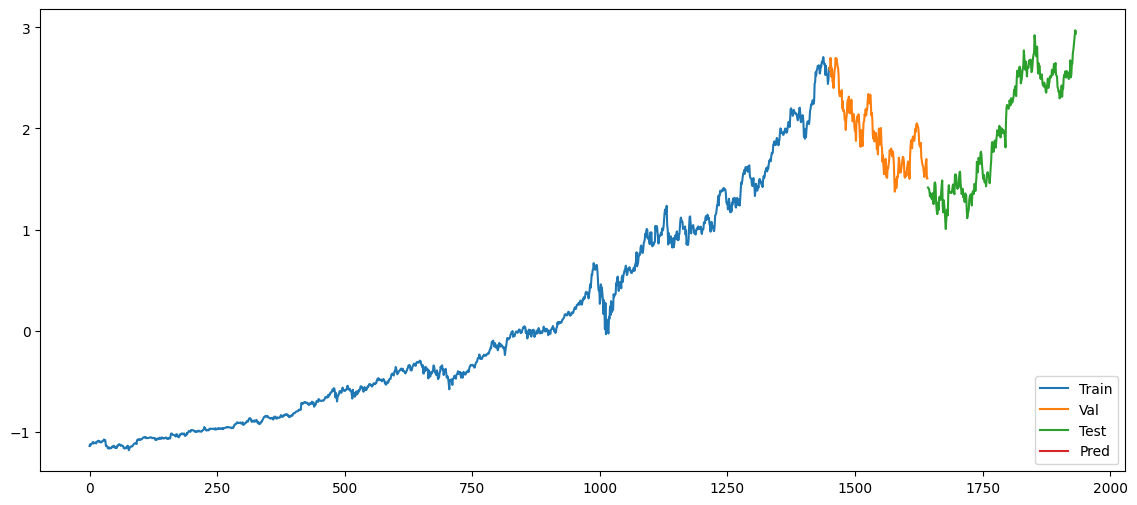

In [53]:
plt.figure(figsize=(14, 6))
plt.plot(range(0,int(len(X)*0.75)),Y_train)
plt.plot(range(int(len(X)*0.75),int(len(X)*0.85)),Y_val)
plt.plot(range(int(len(X)*0.85),len(X)),Y_test)
plt.plot(pred)
# plt.plot(range(len(X),len(X)+200),r_pred)
plt.legend(['Train', 'Val', 'Test', 'Pred', 'Forecast'])

array([2.7903724], dtype=float32)